<a href="https://colab.research.google.com/github/skywalker0803r/ESun2021WinterGame/blob/main/Proof_of_Concept/%E5%88%A9%E7%94%A8apply%E5%8F%96%E4%BB%A3for%E8%BF%B4%E5%9C%88%E4%BE%86%E5%8A%A0%E9%80%9F%E9%81%8B%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
import multiprocessing as mp
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
print("CPU的核数为：{}".format(cpu_count()))
print(type(cpu_count()))
tqdm.pandas()

size = 10000*3
df = pd.DataFrame()
df['dt'] = np.random.randint(0,25,size=size)
df['chid'] = np.random.randint(10000,10000+500,size=size)
df['shop_tag'] = np.random.randint(0,5,size=size)
df = df.sort_values(by='dt')
df

CPU的核数为：12
<class 'int'>


,dt,chid,shop_tag
13848,0,10221,1
14188,0,10231,1
5464,0,10471,4
14184,0,10300,2
22862,0,10370,0
...,...,...,...
19105,24,10036,3
19094,24,10486,2
19087,24,10450,4
19278,24,10345,2


In [62]:
chid = df.loc[1,'chid']
dt = df.loc[1,'dt']
cond = (df.dt>=dt)&(df.chid==chid)
df.loc[cond]

,dt,chid,shop_tag
17898,2,10184,2
24702,2,10184,4
1,2,10184,2
28551,3,10184,3
25506,4,10184,0
21315,4,10184,0
12234,5,10184,3
20899,6,10184,1
747,6,10184,4
24033,7,10184,0


In [63]:
df.loc[cond,'shop_tag'].value_counts()

0    15
1    12
3    10
4     9
2     5
Name: shop_tag, dtype: int64

In [64]:
s = time.time()
answer_list = []
for idx in tqdm(df.index):
  cond = (df.dt>=14)&(df.chid==df.loc[idx,'chid'])
  answer = df.loc[cond,'shop_tag'].value_counts()[:3].index.tolist()
  if len(answer) == 3:
    answer_list.append(answer)
  else:
    remain = 3-len(answer)
    for _ in range(remain):
      answer.append(np.random.choice([0,1,2,3,4]))
    assert len(answer) == 3
    answer_list.append(answer)
answer_list = np.array(answer_list)
df['top1'] = answer_list[:,0]
df['top2'] = answer_list[:,1]
df['top3'] = answer_list[:,2]
df
for_cost_t = time.time() - s

100%|██████████| 30000/30000 [00:29<00:00, 1033.18it/s]


In [65]:
print(for_cost_t)
df

29.073739528656006


,dt,chid,shop_tag,top1,top2,top3
13848,0,10221,1,3,4,1
14188,0,10231,1,3,4,2
5464,0,10471,4,1,0,4
14184,0,10300,2,2,0,4
22862,0,10370,0,4,3,2
...,...,...,...,...,...,...
19105,24,10036,3,4,1,3
19094,24,10486,2,2,0,1
19087,24,10450,4,1,2,0
19278,24,10345,2,4,1,3


In [67]:
s = time.time()
def f(chid):
  cond = (df.dt>=14)&(df.chid==chid)
  answer = df.loc[cond,'shop_tag'].value_counts()[:3].index.tolist()
  if len(answer) == 3:
    return answer
  else:
    remain = 3-len(answer)
    for _ in range(remain):
      answer.append(np.random.choice([0,1,2,3,4]))
    assert len(answer) == 3
    return answer
answer_list = df['chid'].progress_apply(f)
answer_list = answer_list.to_frame()['chid']
df['top1'] = answer_list.apply(lambda x:x[0]).values
df['top2'] = answer_list.apply(lambda x:x[1]).values
df['top3'] = answer_list.apply(lambda x:x[2]).values
df
apply_cost_t = time.time() - s

100%|██████████| 30000/30000 [00:27<00:00, 1091.90it/s]


In [68]:
print(apply_cost_t)
df

27.507057666778564


,dt,chid,shop_tag,top1,top2,top3
13848,0,10221,1,3,4,1
14188,0,10231,1,3,4,2
5464,0,10471,4,1,0,4
14184,0,10300,2,2,0,4
22862,0,10370,0,4,3,2
...,...,...,...,...,...,...
19105,24,10036,3,4,1,3
19094,24,10486,2,2,0,1
19087,24,10450,4,1,2,0
19278,24,10345,2,4,1,3


<BarContainer object of 2 artists>

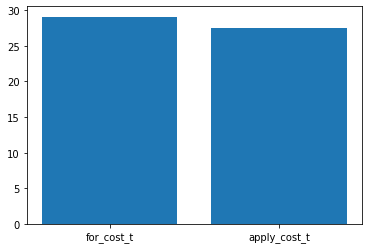

In [69]:
plt.bar(x=['for_cost_t','apply_cost_t'],height=[for_cost_t,apply_cost_t])

In [70]:
s = time.time()
import dask.dataframe as dd
ddf = dd.from_pandas(df, npartitions=cpu_count())
answer_list = ddf['chid'].apply(f,meta=('chid', 'object'))
answer_list = answer_list.to_frame()
ddf['top1'] = answer_list['chid'].apply(lambda x:x[0],meta=('chid', 'object')).values
ddf['top2'] = answer_list['chid'].apply(lambda x:x[1],meta=('chid', 'object')).values
ddf['top3'] = answer_list['chid'].apply(lambda x:x[2],meta=('chid', 'object')).values
ddf.compute()
dask_apply_cost_t = time.time() - s

[########################################] | 100% Completed |  1min 26.4s
[########################################] | 100% Completed |  1min 26.5s
[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 26.6s


<BarContainer object of 3 artists>

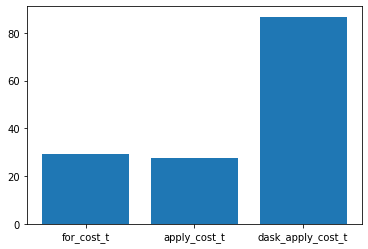

In [71]:
plt.bar(x=['for_cost_t','apply_cost_t','dask_apply_cost_t'],height=[for_cost_t,apply_cost_t,dask_apply_cost_t])